In [1]:
import torch
import numpy as np
import scipy.integrate
from numpy import sin, cos
import matplotlib.pyplot as plt
import random
solver = scipy.integrate.solve_ivp

seed = 36
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.determinstic = True


In [2]:
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
import pandas as pd

BATCH_size = 1000

dftarget = pd.read_csv("./data/target.csv", header=None, dtype=np.float32)
dfinput = pd.read_csv("./data/input.csv", header=None, dtype=np.float32)

pmat = np.array([[1.0,0.0,0.0,0.0], [0.0,0.0,1.0,0.0], [0.0,1.0,0.0,0.0], [0.0,0.0,0.0,1.0]], dtype=np.float32)
dftarget = dftarget @ pmat
dfinput = dfinput @ pmat

X_train, X_test, Y_train, Y_test = train_test_split(dfinput.values, dftarget.values, test_size=0.2)

# train data
data_train = data_utils.TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_size, shuffle=True)

# test data
data_test = data_utils.TensorDataset(torch.tensor(X_test), torch.tensor(Y_test))
test_loader = torch.utils.data.DataLoader(data_test, batch_size=BATCH_size, shuffle=True)

In [3]:
import torch.nn as nn
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#!nvidia-smi


In [4]:
N = 2
O = np.zeros((N,N))
Id = np.eye(N)
S = np.vstack([np.hstack([O,Id]),np.hstack([-Id,O])])
St = torch.tensor(-S, dtype=torch.float32).to(device)
class MLP(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super(MLP,self).__init__()
    self.l1 = nn.Linear(input_size,hidden_size)
    self.l2 = nn.Linear(hidden_size,hidden_size)
    self.l3 = nn.Linear(hidden_size,output_size)
  
  def forward(self,x):
    x = self.l1(x)
    x = torch.tanh(x)
    x = self.l2(x)
    x = torch.tanh(x)
    x = self.l3(x)
    return x

  def grad(self,x):
    x = x.requires_grad_(True)
    with torch.enable_grad():
      hamiltonian = self(x)
      gradient = torch.autograd.grad(hamiltonian.sum(),x,create_graph=True,retain_graph=True)
    return torch.matmul(gradient[0],St)

  def fvec(self,t,x):
    return self.grad(x)

In [5]:
import time
input_size = 4
output_size = 1
hidden_size = 200
num_trials = 10
stats = {'train_loss': [], 'eval_loss': [], 'computation_time': []}

for trial in range(num_trials):
  mynet = MLP(input_size,hidden_size,output_size).to(device)
  num_epochs = 2000

  criterion = nn.MSELoss()

  optimizer = optim.Adam(params=mynet.parameters(),lr=0.001)

  history_loss = []
  history_eval = []
  history_acc = []

  cnt = 0
  startt = time.time()
  for epoch in range(num_epochs):
    mynet.train()

    total_loss = 0.0
    eval_loss = 0.0
    cnt = 0
    for i,(data,target) in enumerate(train_loader):
      optimizer.zero_grad()
      output = mynet.grad(data.to(device))

      loss = criterion(output,target.to(device))
      loss.backward()
      optimizer.step()

      total_loss = total_loss+loss.cpu().item()
      cnt = cnt + 1
    total_loss = total_loss/cnt

    num_correct = 0
    num_data = 0
    mynet.eval()
    eval_loss = 0.0
    cnt = 0
    for i,(data,target) in enumerate(test_loader):
      output = mynet.grad(data.to(device))
      eval_loss = eval_loss+criterion(output,target.to(device)).cpu().item()
      cnt = cnt + 1
    eval_loss = eval_loss/cnt
  
    history_loss.append(total_loss)
    history_eval.append(eval_loss)

  
  print("{}/{} training loss:{},evaluation loss:{}".format(epoch+1,num_epochs,total_loss,eval_loss))
  path = "./model/hnn_dp_2t_{}".format(trial)
  torch.save(mynet.state_dict(), path)  
  stats['train_loss'].append(total_loss)
  stats['eval_loss'].append(eval_loss)
  stats['computation_time'].append(time.time() - startt)

print("train_loss:{}, std: {}".format(np.mean(stats['train_loss']), np.std(stats['train_loss'])))
print("test_loss:{}, std: {}".format(np.mean(stats['eval_loss']), np.std(stats['eval_loss'])))
print("computation_time:{}, std: {}".format(np.mean(stats['computation_time']), np.std(stats['computation_time'])))


2000/2000 training loss:0.0008369989584025462,evaluation loss:0.0008962535997852683
2000/2000 training loss:0.0008156459021847695,evaluation loss:0.0008359658022527583
2000/2000 training loss:0.0007939839542814298,evaluation loss:0.0008706996086402796
2000/2000 training loss:0.0008147240791004151,evaluation loss:0.0008585907184169628
2000/2000 training loss:0.0008314915805385681,evaluation loss:0.0008767190505750477
2000/2000 training loss:0.0008148886863637017,evaluation loss:0.0008889037315384484
2000/2000 training loss:0.0008206547980080358,evaluation loss:0.000918935397930909
2000/2000 training loss:0.0008061873944825493,evaluation loss:0.000838033809850458
2000/2000 training loss:0.0007893153477198211,evaluation loss:0.0008424240819294937
2000/2000 training loss:0.0007987297591171228,evaluation loss:0.0008694188407389447
train_loss:0.0008122620460198959, std: 1.4687420561451814e-05
test_loss:0.000869594464165857, std: 2.5605411297038538e-05
computation_time:1549.3918818473817, std

In [7]:
A = pd.read_csv("./data/A.csv", header=None, dtype=np.float32)
B = pd.read_csv("./data/B.csv", header=None, dtype=np.float32)
#A = np.mat(A)@pmat # `np.mat` was removed in the NumPy 2.0 release. Use `np.asmatrix` instead.
#B = np.mat(B)@pmat
A = np.asmatrix(A)
B = np.asmatrix(B)

[0.73424656 0.6566721  0.42773057 0.74193278]


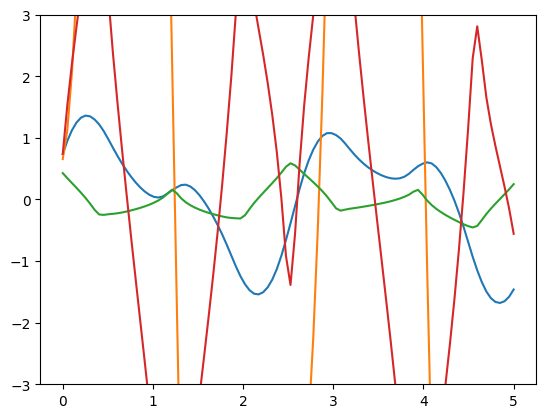

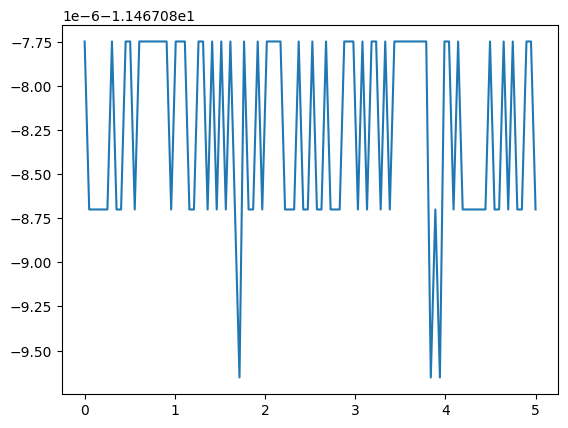

energy_error0:-9.5367431640625e-07
energy_error0:5.486416486079195


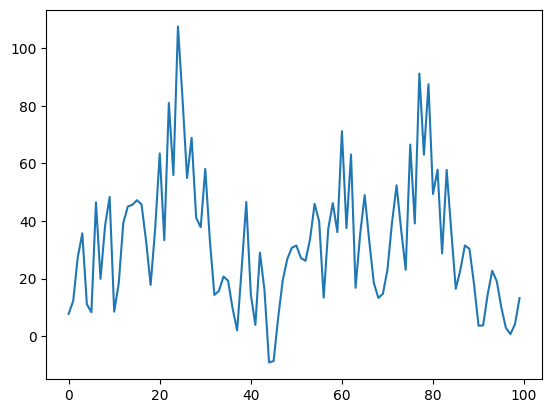

[0.3391952  0.01912268 0.42160305 0.99741402]


/tmp/ipykernel_6089/2342382861.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A, dtype=torch.float32)
/tmp/ipykernel_6089/2342382861.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  B = torch.tensor(B, dtype=torch.float32)


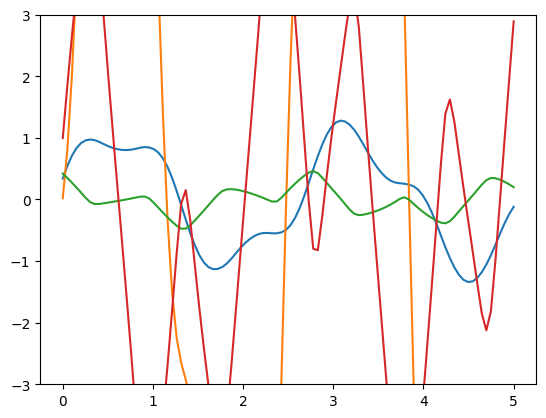

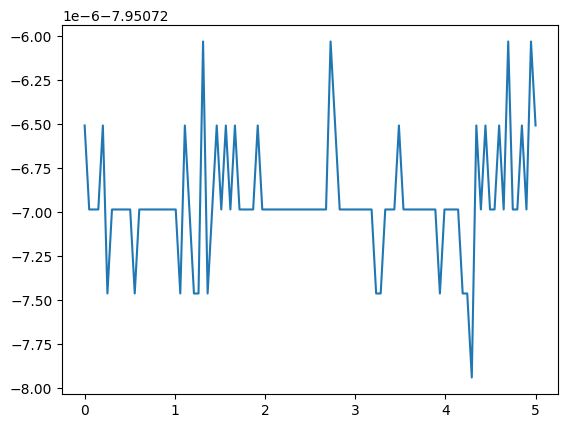

energy_error1:0.0
energy_error1:38.49584524749729


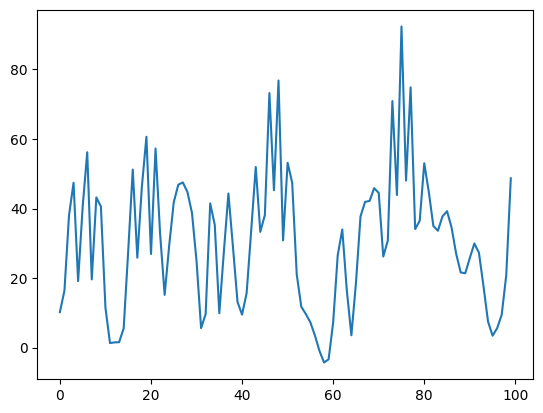

[0.03656911 0.92395591 0.23967218 0.95224603]


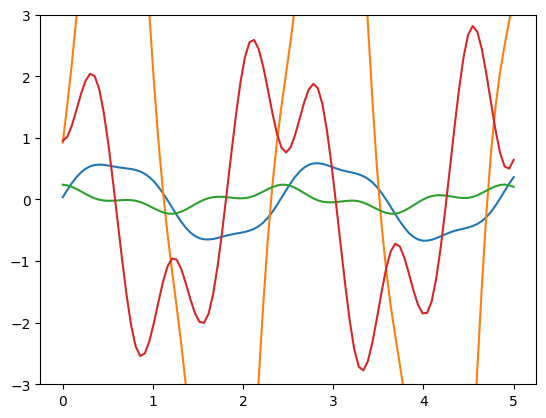

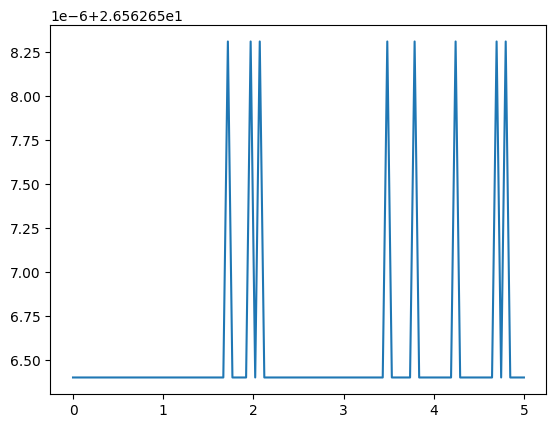

energy_error2:0.0
energy_error2:28.185792285020295


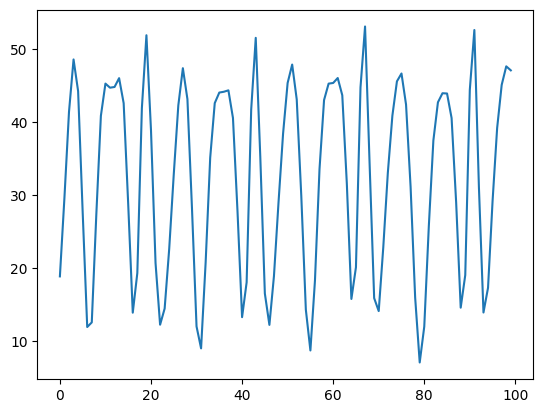

[0.26485681 0.29738391 0.98458253 0.46614086]


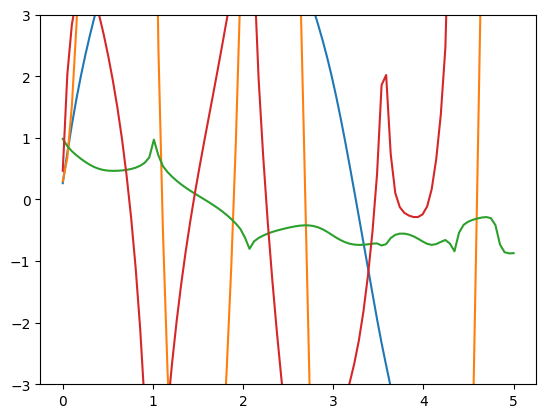

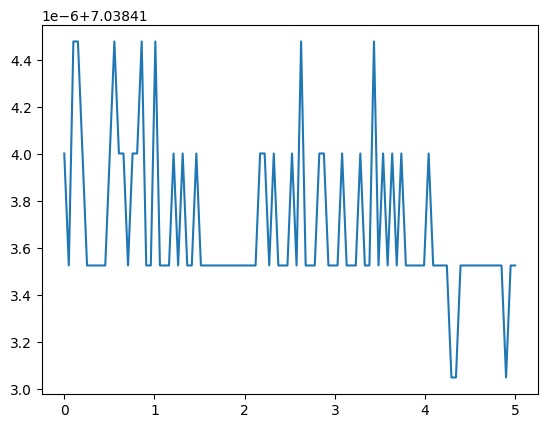

energy_error3:-4.76837158203125e-07
energy_error3:143.88780413521656


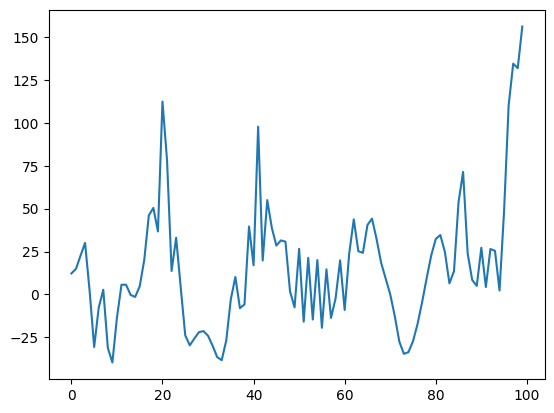

[0.95620719 0.08908681 0.10023305 0.73110729]


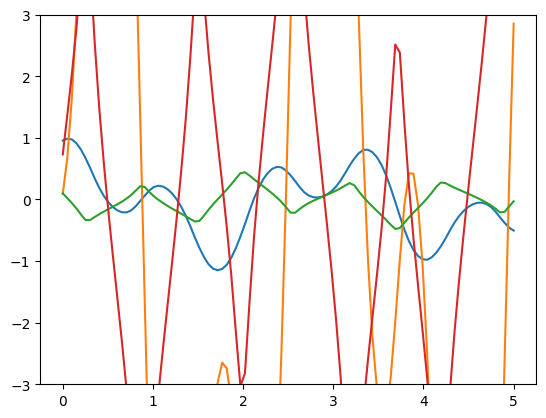

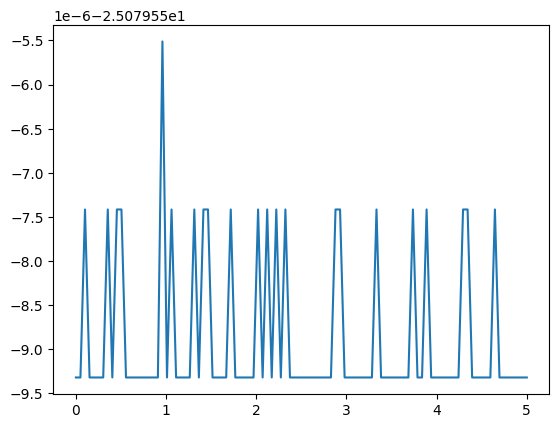

energy_error4:0.0
energy_error4:62.320603199565866


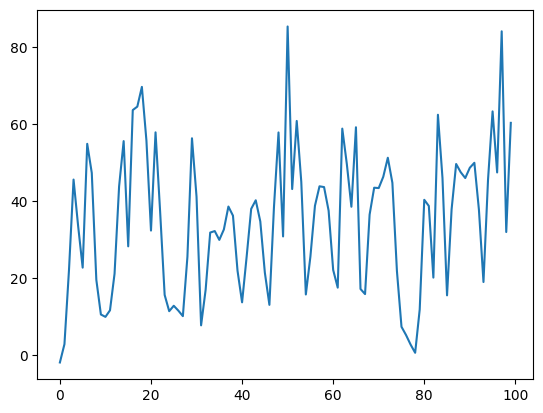

[0.56925707 0.38088485 0.51448741 0.89776162]


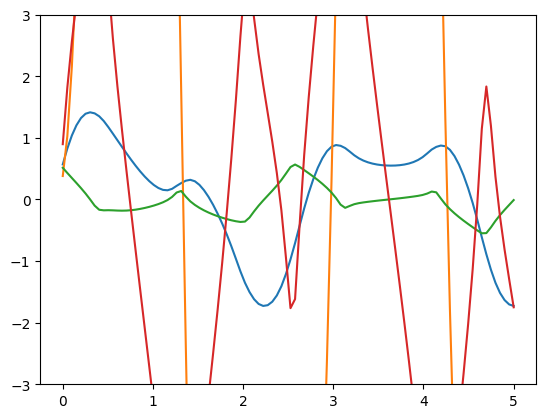

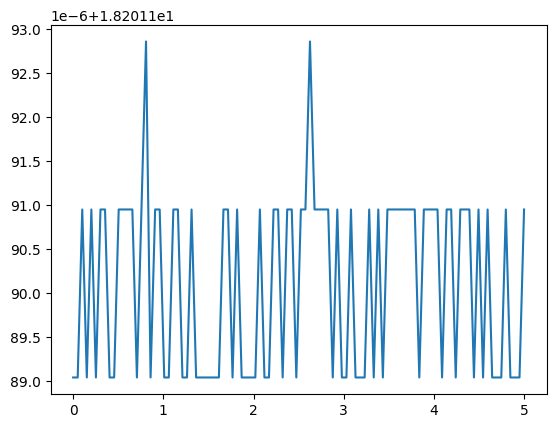

energy_error5:1.9073486328125e-06
energy_error5:4.661320462068531


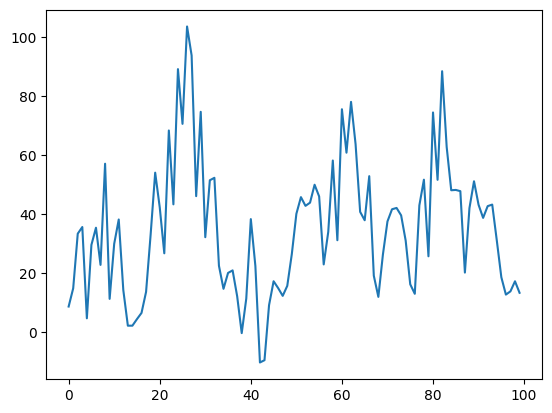

[0.57982002 0.89532277 0.52784278 0.28848429]


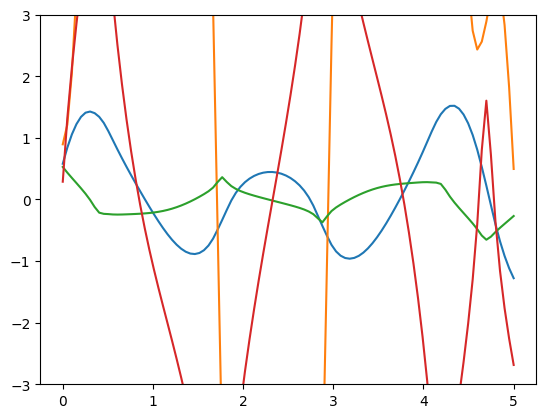

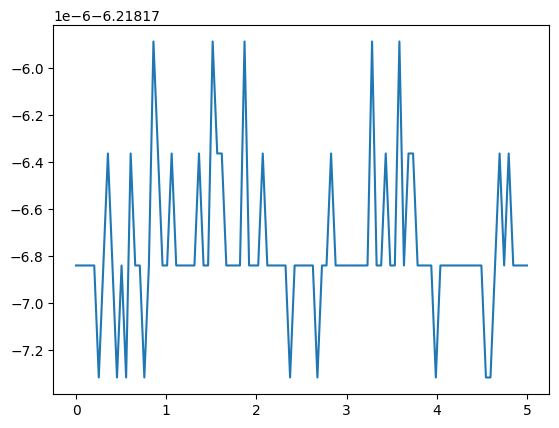

energy_error6:0.0
energy_error6:-14.84890010650278


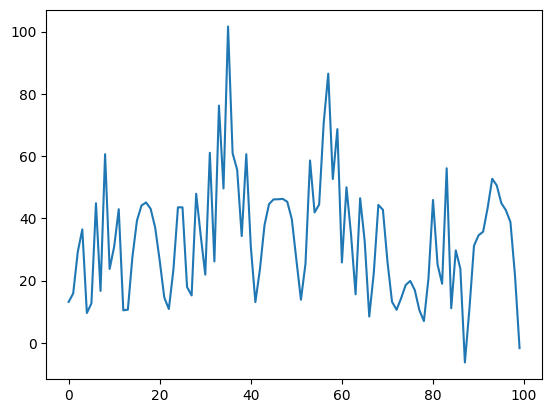

[0.40574935 0.55496527 0.98283737 0.54627115]


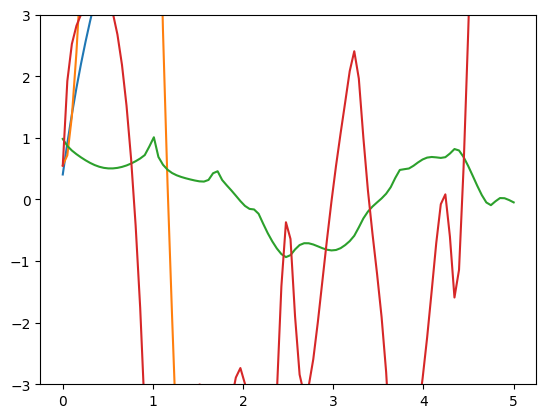

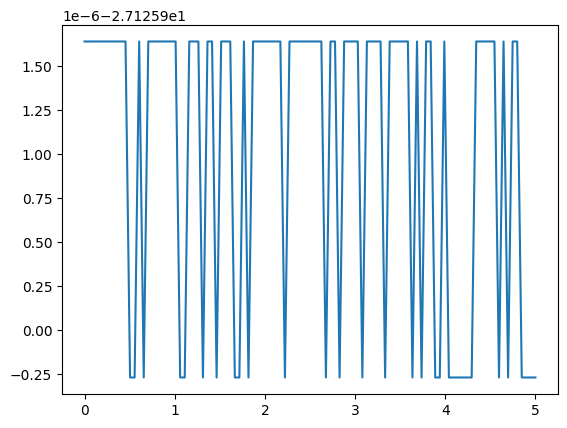

energy_error7:-1.9073486328125e-06
energy_error7:82.27589898212317


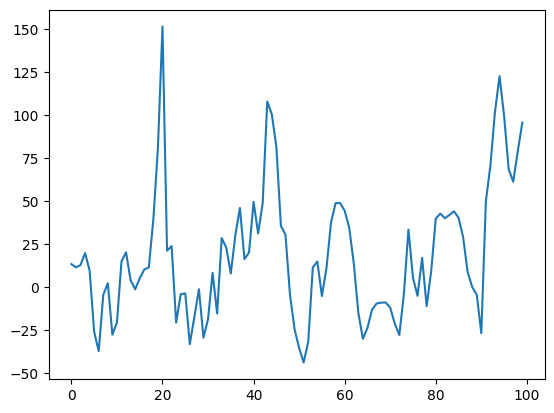

[0.63119862 0.3641424  0.44832169 0.35867564]


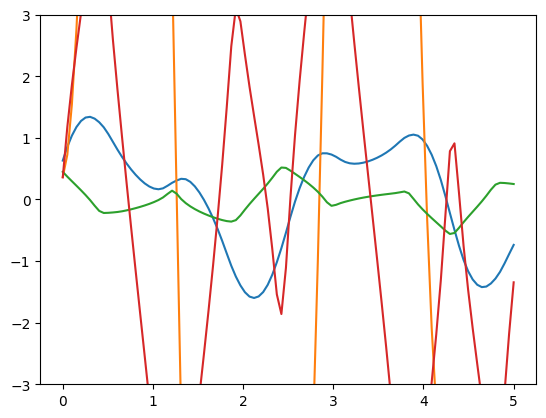

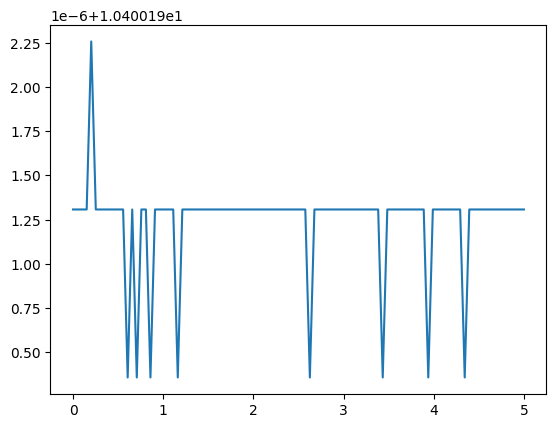

energy_error8:0.0
energy_error8:13.985672513479365


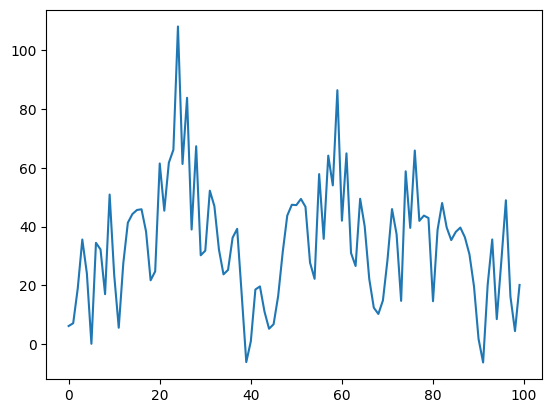

[0.17174863 0.36357341 0.30217936 0.96340619]


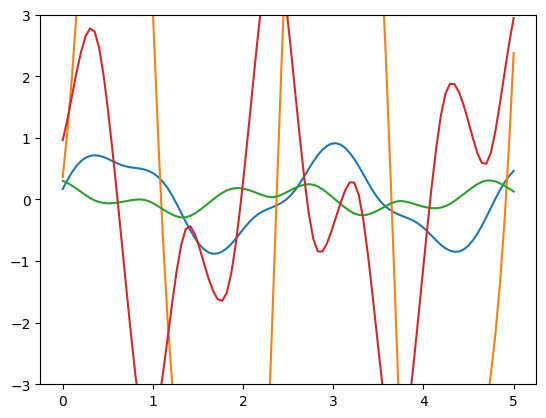

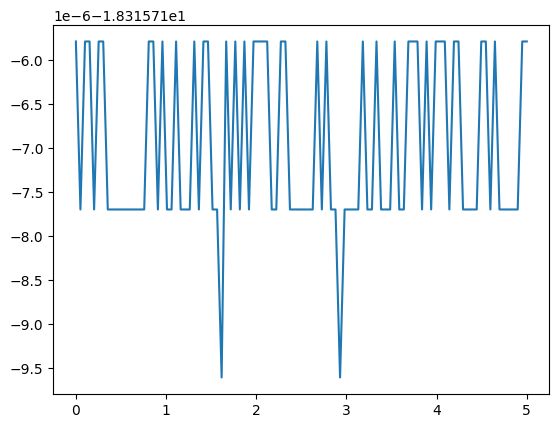

energy_error9:0.0
energy_error9:36.59349252397274


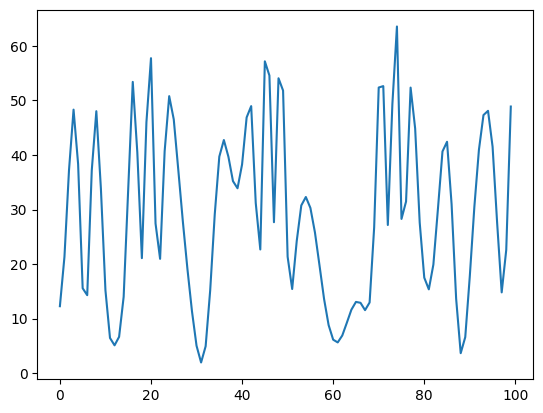

eq_error:[np.float64(5.486416486079195), np.float64(38.49584524749729), np.float64(28.185792285020295), np.float64(143.88780413521656), np.float64(62.320603199565866), np.float64(4.661320462068531), np.float64(-14.84890010650278), np.float64(82.27589898212317), np.float64(13.985672513479365), np.float64(36.59349252397274)] net_error:[np.float32(-9.536743e-07), np.float32(0.0), np.float32(0.0), np.float32(-4.7683716e-07), np.float32(0.0), np.float32(1.9073486e-06), np.float32(0.0), np.float32(-1.9073486e-06), np.float32(0.0), np.float32(0.0)]
eq_error:43.07417459415258, std: 43.99616676742455
net_error:5.245208853921213e-07, std: 9.059905892172537e-07
eq_error:32.38964240449652
net_error:0.0


In [8]:
# simulation
# parameters
g = 9.8
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
m = m1+m2
eq_error = []
net_error = []
for trial in range(num_trials):
  mynet.load_state_dict(torch.load("./model/hnn_dp_2t_{}".format(trial), map_location="cpu"))
  mynet.eval()
  teval = torch.linspace(0.0,5.0,100)
  x0 = np.random.rand(4)
  #x0 = (0.01825532, 0.52412613, 0.33688556, 0.20706259)
  print(x0)
  dt = teval[1]-teval[0]
  St = torch.tensor(-S, dtype=torch.float32)
  teval = teval.detach().cpu().numpy()
  A = torch.tensor(A, dtype=torch.float32)
  B = torch.tensor(B, dtype=torch.float32)
  mynet.eval()
  mynet.cpu()
  def fvec_np(x,t):
    tx = torch.tensor(x, dtype=torch.float)
    x = torch.matmul(tx, torch.inverse(B))
    output = mynet.grad(x).squeeze(0)
    output = torch.matmul(A, output)
    output = output.squeeze(0)    
    return output.detach().cpu().numpy()

  res = scipy.integrate.odeint(fvec_np,x0,teval)

  ax=plt.subplot()
  ax.set_ylim([-3,3])
  ax.plot(teval,res[:,0])
  ax.plot(teval,res[:,1])
  ax.plot(teval,res[:,2])
  ax.plot(teval,res[:,3])
  
  plt.show()
  def net_energy(x,t):
    tx = torch.tensor(x, dtype=torch.float)
    x = torch.matmul(tx, torch.inverse(B))
    ne = mynet.forward(x).squeeze(0)
    return ne.detach().cpu().numpy()

  net_energy = net_energy(res, teval).reshape((100))
  plt.plot(teval,net_energy)
  plt.show()
  net_energy_error=net_energy[99]-net_energy[0]
  print("energy_error{}:{}".format(trial,net_energy_error))
    
  energy = (1/2)*(m1+m2)*np.square(l1)*np.square(res[:,2])+(1/2)*m2*np.square(l2)*np.square(res[:,3])+m2*l1*l2*res[:,2]*res[:,3]*np.cos(res[:,0]-res[:,1])+g*(m1+m2)*l1*np.cos(res[:,0])-g*m2*l2*np.cos(res[:,1])
  energy_error=energy[99]-energy[0]
  print("energy_error{}:{}".format(trial,energy_error))
  plt.plot(energy)
  plt.show()

  eq_error.append(energy_error)
  net_error.append(net_energy_error)

      
print("eq_error:{}".format(eq_error),"net_error:{}".format(net_error))
print("eq_error:{}, std: {}".format(np.mean(np.abs(eq_error)), np.std(eq_error)))
print("net_error:{}, std: {}".format(np.mean(np.abs(net_error)), np.std(net_error)))
print("eq_error:{}".format(np.median(np.abs(eq_error))))
print("net_error:{}".format(np.median(np.abs(net_error))))

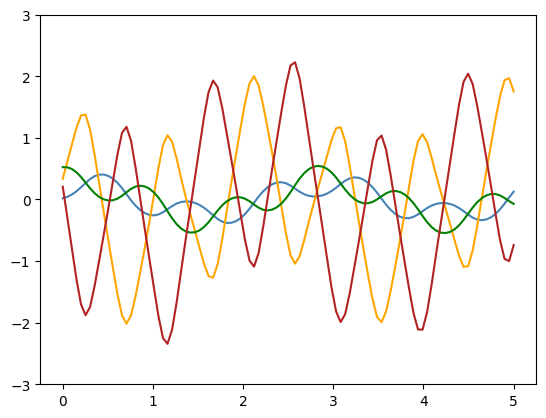

In [9]:
# Ground truth
# parameters
g = 9.8
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
m = m1+m2
# equations of motion
def func(t, state):
  cosv = np.cos(state[0]-state[1])
  sinv = np.sin(state[0]-state[1])
  dvdt = np.zeros_like(state)
  dvdt[0] = state[2]
  dvdt[1] = state[3]
  dvdt[2] = (g*(np.sin(state[1])*cosv - m/m2*np.sin(state[0])) - (l1*state[2]*state[2]*cosv + l2* state[3]*state[3])*sinv) / (l1*(m/m2-cosv*cosv))
  dvdt[3] = (g*m/m2*(np.sin(state[0])*cosv - np.sin(state[1])) + sinv * (l1*state[2]*state[2]*m/m2 + l2* state[3]*state[3]*cosv)) / (l2*(m/m2-cosv*cosv))
  return dvdt

#　the time grid
M = 100
tend = 5.0
t_eval = np.linspace(0,tend,M)
dt = t_eval[1]-t_eval[0]

state = []
for i in range(1):
  s = (0.01825532, 0.52412613, 0.33688556, 0.20706259 )
  state.append(s)
p1 = []
v1 = []
p2 = []
v2 = []
flag = False
for i in range(1):
  sol = solver(func, [0, tend], state[i], t_eval=t_eval)
  tval = sol['t']
  q1 = sol['y'][0]
  q2 = sol['y'][1]
  v1 = sol['y'][2]
  v2 = sol['y'][3]
  ax=plt.subplot()
  ax.set_ylim([-3,3])
  ax.plot(tval, q1, 'steelblue')
  ax.plot(tval, v1, 'orange')
  ax.plot(tval, q2, 'g')
  ax.plot(tval, v2, 'firebrick')
  plt.show()